In [ ]:
%load_ext autoreload
%autoreload 2
import tifffile as tiff
import numpy as np
import sys
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
import bm3d,bm4d
from tqdm import tqdm
from pickle import dump,load

sys.path.append(str(Path("..").resolve()))
from src import *

# Denoising with Block-Matching algorithms

ℹ️ This notebook requires the samples of OABF dataset in the `dataset/sample/motion_corrected` folder generated with [1.1.1-Visualize_OABF_Dataset](../1-eda/1.1.1-Visualize_OABF_Dataset.ipynb).

BM3D and BM4D were the State-of-the-art in image denoising back in 2010. How do they perform when compared to DeepCAD?

In [3]:
astro_x_path = SAMPLE_DIR / "motion_corrected" / "oabf_astro.tiff"
astro_y_path = SAMPLE_DIR / "deepcad" / "oabf_astro.tiff"
vpm_x_path = SAMPLE_DIR / "motion_corrected" / "oabf_vpm.tiff"
vpm_y_path = SAMPLE_DIR / "deepcad" / "oabf_vpm.tiff"
resonant_neuro_x_path = SAMPLE_DIR / "motion_corrected" / "oabf_resonant_neuro.tiff"

In [4]:
# 14s
astro_x, astro_y = Recording(astro_x_path), Recording(astro_y_path)
vpm_x, vpm_y = Recording(vpm_x_path), Recording(vpm_y_path)
resonant_neuro_x = Recording(resonant_neuro_x_path)

The values must be ranged 0-1 because `sigma_psd` depends on it.

## BM3D denoising

In [ ]:
# 11s
bm3D_all = []
for x in tqdm((astro_x, vpm_x, resonant_neuro_x)):
    bm3D_all.append(bm3d.bm3d(x.video[0], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES))

In [19]:
psnr=peak_signal_noise_ratio(astro_y.video[0], bm3D_all[0], data_range=1)
ssim=structural_similarity(astro_y.video[0], bm3D_all[0], data_range=1)
cprint('PSNR','red:(DeepCAD - BM4D_All)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM4D_All)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM4D_All) --> 27.23dB
SSIM (DeepCAD - BM4D_All) --> 0.677


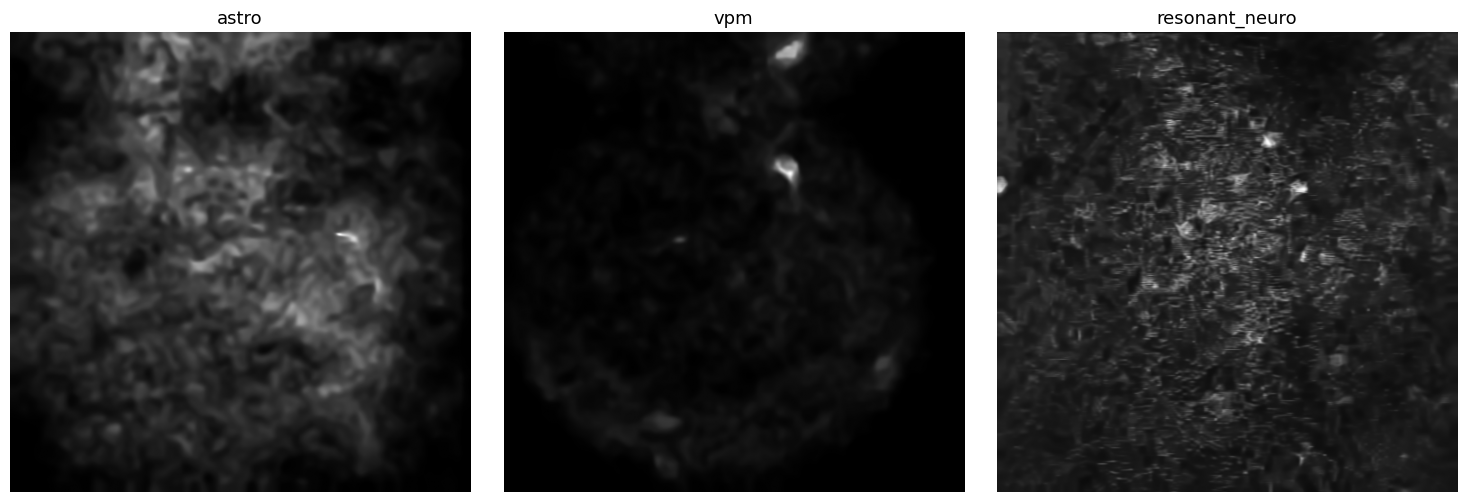

In [16]:
imshow({"astro": bm3D_all[0], "vpm": bm3D_all[1], "resonant_neuro": bm3D_all[2]}, size=5, cmap="gray")

BM3D is meant to be used with natural images. It does not perform well with neuroscience images. But BM4D will perform much better because we have a video with independent noise at pixel and frame level.

## BM4D

In [ ]:
# 7.5s/frame (scales O(n) with the number of frames)
bm4D_all = []
for x in tqdm((astro_x, vpm_x, resonant_neuro_x)):
    bm4D_all.append(bm4d.bm4d(x.video[:8], sigma_psd=0.2, stage_arg=bm3d.BM3DStages.ALL_STAGES))
dump([_[0] for _ in bm4D_all],open("bm4D_all.pkl","wb"))

100%|██████████| 3/3 [03:24<00:00, 68.23s/it]


In [ ]:
bm4D_all=load(open("bm4D_all.pkl","rb"))

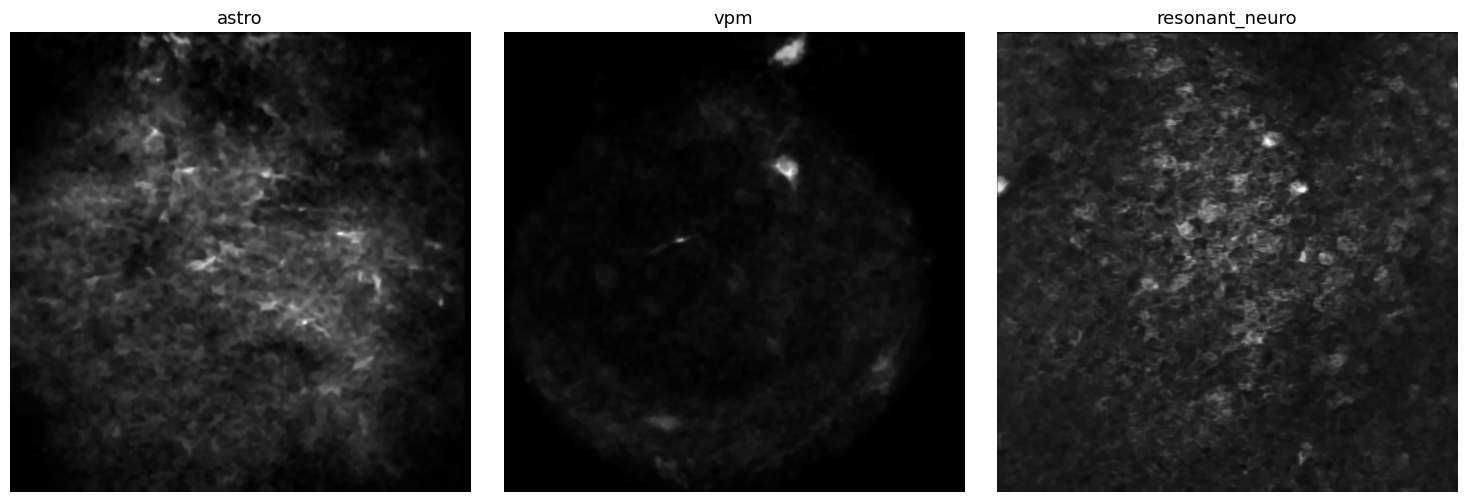

In [27]:
imshow({"astro": bm4D_all[0], "vpm": bm4D_all[1], "resonant_neuro": bm4D_all[2]}, size=5, cmap="gray")

In [18]:
psnr=peak_signal_noise_ratio(astro_y.video[:8], bm4D_all[0], data_range=1)
ssim=structural_similarity(astro_y.video[:8], bm4D_all[0], data_range=1)
cprint('PSNR','red:(DeepCAD - BM4D_All)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM4D_All)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM4D_All) --> 27.47dB
SSIM (DeepCAD - BM4D_All) --> 0.686


BM4D (Maggioni et al. 2012) is much better than BM3D (Dabov et al. 2007), but too computational expensive.